In [24]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


In [25]:
boston = pd.read_csv('Data/Boston.csv')
boston = boston.fillna(-1)
boston.drop('Unnamed: 0', axis=1, inplace=True)
boston = pd.get_dummies(boston, columns=['rad'])
target = 'medv'
X = boston.copy().drop(target, axis=1)
y = boston[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

In [27]:
pipeline = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42))
])

params = {
    'rf__max_depth': [8, 10, 15, 20, 30, 40],
    'rf__max_features': ['log2', 'sqrt', 10, 12]
}

rf_grid = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='r2', param_grid=params)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [8, 10, 15, 20, 30, 40],
                         'rf__max_features': ['log2', 'sqrt', 10, 12]},
             scoring='r2')

In [28]:
rf_grid.best_params_

{'rf__max_depth': 15, 'rf__max_features': 10}

In [29]:
best_model = rf_grid.best_estimator_.named_steps['rf']

In [30]:
predicciones_rf = best_model.predict(X_test)

r2_score(y_pred=predicciones_rf, y_true=y_test)

0.8932209934754679

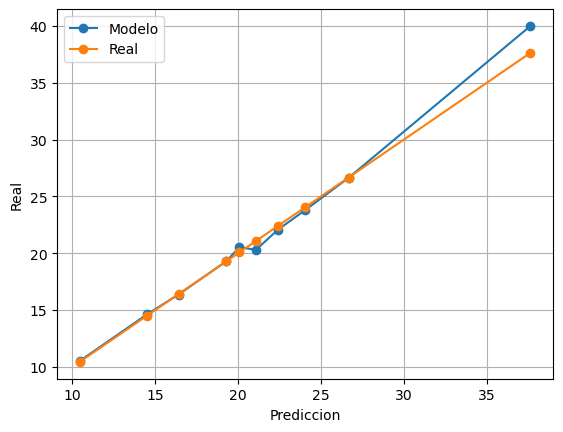

In [31]:
calibracion(predicciones_rf, y_test, 10)

In [32]:
model_interpretability = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})
model_interpretability

,variables,importancia
0,crim,0.048310
1,zn,0.003541
2,indus,0.037459
3,chas,0.005464
4,nox,0.046609
5,rm,0.383334
6,age,0.021161
7,dis,0.051489
8,tax,0.026353
9,ptratio,0.043649


In [33]:
top_5_variables = model_interpretability.nlargest(5, 'importancia')
print(top_5_variables)


   variables  importancia
5         rm     0.383334
10     lstat     0.320742
7        dis     0.051489
0       crim     0.048310
4        nox     0.046609


# Conclusiones

Utilizando el random forest 